In [168]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.interpolate import interp1d
from sklearn.model_selection import GridSearchCV
from numpy.polynomial import Polynomial

In [169]:
gen1_train = pd.read_csv("gen1_train_comp_final.csv")
gen2_train = pd.read_csv("gen2_train_comp_final.csv")
gen1_test = pd.read_csv("gen1_test_comp_final.csv")
gen2_test = pd.read_csv("gen2_test_upto9_comp_final.csv")

In [170]:
gen1_train.head()

,gen1_id,sex_assigned_at_birth,age,SHgt_cm
0,774,F,0.10,56.961812
1,774,F,0.25,64.826190
2,774,F,0.50,74.340764
3,774,F,0.75,79.747338
4,774,F,1.00,84.092569


In [171]:
gen1_test.head()

,gen1_id,sex_assigned_at_birth,age,SHgt_cm
0,768,F,0.10,53.822825
1,768,F,0.25,61.455579
2,768,F,0.50,69.757527
3,768,F,0.75,73.385477
4,768,F,1.00,78.129137


In [172]:
gen2_train.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
0,3012,M,mother,636,0.10,56.251625,4.636903
1,3012,M,mother,636,0.25,64.491579,NaN
2,3012,M,mother,636,0.50,70.465927,NaN
3,3012,M,mother,636,0.75,73.992677,NaN
4,3012,M,mother,636,1.00,79.343537,NaN


In [173]:
gen2_test.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
0,2831,F,mother,455,0.10,52.912025,NaN
1,2831,F,mother,455,0.25,59.532779,NaN
2,2831,F,mother,455,0.50,67.733527,NaN
3,2831,F,mother,455,0.75,70.450677,NaN
4,2831,F,mother,455,1.00,74.991937,NaN


In [174]:
# Changing parent sex
gen2_train.loc[gen2_train['gen2_id'] == 2517, 'study_parent_sex'] = 'father'
gen2_train.loc[gen2_train['gen2_id'] == 3012, 'study_parent_sex'] = 'father'

In [175]:
gen2_test.isna().sum()

gen2_id                    0
sex_assigned_at_birth      0
study_parent_sex           0
study_parent_id_new        0
AgeGr                      0
SHgt_cm                  132
Wgt_kg                   823
dtype: int64

In [176]:
gen1_train['SHgt_cm'] = gen1_train.groupby('gen1_id')['SHgt_cm'].transform(lambda x: x.interpolate(method="polynomial", order=3))
gen1_test['SHgt_cm'] = gen1_test.groupby('gen1_id')['SHgt_cm'].transform(lambda x: x.interpolate(method="polynomial", order=3))

gen2_train['SHgt_cm'] = gen2_train.groupby('gen2_id')['SHgt_cm'].transform(lambda x: x.interpolate(method="polynomial", order=0))
gen2_test['SHgt_cm'] = gen2_test.groupby('gen2_id')['SHgt_cm'].transform(lambda x: x.interpolate(method="polynomial", order=1))

# gen2_train['Wgt_kg'] = gen2_train.groupby('gen2_id')['Wgt_kg'].transform(lambda x: x.interpolate(method="polynomial", order=3))
# gen2_test['Wgt_kg'] = gen2_test.groupby('gen2_id')['Wgt_kg'].transform(lambda x: x.interpolate(method="polynomial", order=3))

In [177]:
# Imputing height  and weight with mean of same sex and age for remaining missing values
gen1_train['SHgt_cm'] = gen1_train.groupby(['sex_assigned_at_birth', 'age'])['SHgt_cm'].transform(lambda x: x.fillna(x.median()))
gen1_test['SHgt_cm'] = gen1_test.groupby(['sex_assigned_at_birth', 'age'])['SHgt_cm'].transform(lambda x: x.fillna(x.median()))

gen2_train['SHgt_cm'] = gen2_train.groupby(['sex_assigned_at_birth', 'AgeGr'])['SHgt_cm'].transform(lambda x: x.fillna(x.median()))
gen2_test['SHgt_cm'] = gen2_test.groupby(['sex_assigned_at_birth', 'AgeGr'])['SHgt_cm'].transform(lambda x: x.fillna(x.median()))

# gen2_train['Wgt_kg'] = gen2_train.groupby(['sex_assigned_at_birth', 'AgeGr'])['Wgt_kg'].transform(lambda x: x.fillna(x.median()))
# gen2_test['Wgt_kg'] = gen2_test.groupby(['sex_assigned_at_birth', 'AgeGr'])['Wgt_kg'].transform(lambda x: x.fillna(x.median()))


In [178]:
gen2_train.isna().sum()

gen2_id                     0
sex_assigned_at_birth       0
study_parent_sex            0
study_parent_id_new         0
AgeGr                       0
SHgt_cm                     0
Wgt_kg                   2045
dtype: int64

In [179]:
# Merge parent and children training sets (dropping weight for now) and using inner join

merged_train = gen2_train.merge(gen1_train, how='left', left_on=['study_parent_id_new','AgeGr'], right_on=['gen1_id', 'age'])

merged_train = merged_train.drop(['study_parent_sex', 'study_parent_id_new', 'Wgt_kg'], axis=1)

merged_train = merged_train.rename({'gen1_id':'parent_id', 'sex_assigned_at_birth_x':'child_sex', 
                     'age':'parent_age', 'SHgt_cm_x':'child_height', 'gen2_id':'child_id',
                     'sex_assigned_at_birth_y':'parent_sex', 'AgeGr':'child_age', 
                     'SHgt_cm_y':'parent_height'}, axis=1)

merged_train.head()

,child_id,child_sex,child_age,child_height,parent_id,parent_sex,parent_age,parent_height
0,3012,M,0.10,56.251625,636.0,M,0.10,53.818812
1,3012,M,0.25,64.491579,636.0,M,0.25,61.276841
2,3012,M,0.50,70.465927,636.0,M,0.50,68.828343
3,3012,M,0.75,73.992677,636.0,M,0.75,75.452930
4,3012,M,1.00,79.343537,636.0,M,1.00,77.834870


In [180]:
# Merge parent and children test sets (dropping weight for now)

merged_test = gen2_test.merge(gen1_test, how='left', left_on=['study_parent_id_new','AgeGr'], right_on=['gen1_id', 'age'])

merged_test = merged_test.drop(['study_parent_sex', 'study_parent_id_new', 'Wgt_kg'], axis=1)

merged_test = merged_test.rename({'gen1_id':'parent_id', 'sex_assigned_at_birth_x':'child_sex', 
                     'age':'parent_age', 'SHgt_cm_x':'child_height', 'gen2_id':'child_id',
                     'sex_assigned_at_birth_y':'parent_sex', 'AgeGr':'child_age', 
                     'SHgt_cm_y':'parent_height'}, axis=1)

merged_test.head()

,child_id,child_sex,child_age,child_height,parent_id,parent_sex,parent_age,parent_height
0,2831,F,0.10,52.912025,NaN,NaN,NaN,NaN
1,2831,F,0.25,59.532779,NaN,NaN,NaN,NaN
2,2831,F,0.50,67.733527,NaN,NaN,NaN,NaN
3,2831,F,0.75,70.450677,NaN,NaN,NaN,NaN
4,2831,F,1.00,74.991937,NaN,NaN,NaN,NaN


In [181]:
le = LabelEncoder()
columns_to_encode = ['parent_sex', 'child_sex']

for col in columns_to_encode:
    merged_train[col] = le.fit_transform(merged_train[col])
    merged_test[col] = le.fit_transform(merged_test[col])

In [182]:
X_train = (
    merged_train[merged_train["child_age"] <= 9]
    .pivot(index="child_id", columns="child_age", values="child_height")
)

# Rename columns to reflect age-based features
X_train.columns = [f"height_at_age_{age}" for age in X_train.columns]

# Add parent-related features (aggregated)
parent_features = merged_train.groupby("child_id").agg(
    parent_max_height=("parent_height", "max"),
    parent_min_height=("parent_height", "min"),
    parent_mean_height=("parent_height", "mean"),
    growth_poly_coef1=("parent_height", lambda x: Polynomial.fit(range(len(x)), x, deg=2).coef[1]),
    growth_poly_coef2=("parent_height", lambda x: Polynomial.fit(range(len(x)), x, deg=2).coef[2])
)
X_train = X_train.merge(parent_features, left_index=True, right_index=True)


In [183]:
y_train = (
    merged_train[merged_train["child_age"] > 9]
    .pivot(index="child_id", columns="child_age", values="child_height")
)

# Rename target columns
y_train.columns = [f"target_height_at_age_{int(age)}" for age in y_train.columns]


In [184]:
X_train.head()

,height_at_age_0.1,height_at_age_0.25,height_at_age_0.5,height_at_age_0.75,height_at_age_1.0,height_at_age_1.5,height_at_age_2.0,height_at_age_3.0,height_at_age_4.0,height_at_age_5.0,height_at_age_6.0,height_at_age_7.0,height_at_age_8.0,height_at_age_9.0,parent_max_height,parent_min_height,parent_mean_height,growth_poly_coef1,growth_poly_coef2
child_id,,,,,,,,,,,,,,,,,,,
1332,54.098866,59.128432,67.256015,72.511388,74.886310,85.617761,91.007144,99.977795,109.291388,114.288786,122.593692,129.000198,135.387613,139.082846,NaN,NaN,NaN,NaN,NaN
2330,54.481503,61.191237,66.362172,69.582869,75.855070,80.153012,87.153373,93.533053,93.533053,106.860775,112.210703,117.287960,121.884913,126.219288,NaN,NaN,NaN,NaN,NaN
2331,57.920127,57.920127,70.718045,70.718045,79.118851,79.118851,89.661203,98.039558,103.095061,109.464829,115.526379,122.509083,129.665665,134.683255,NaN,NaN,NaN,NaN,NaN
2505,58.894508,62.822452,68.207623,72.622024,78.192172,85.216314,91.741224,100.252722,105.917235,111.278205,118.535163,124.109775,128.778979,133.779827,NaN,NaN,NaN,NaN,NaN
2507,54.436597,61.947728,68.443083,72.281629,74.854322,83.284637,90.811808,101.297097,110.018713,117.068854,123.634620,132.016706,137.989206,144.463483,NaN,NaN,NaN,NaN,NaN


In [185]:
y_train.head()

,target_height_at_age_10,target_height_at_age_11,target_height_at_age_12,target_height_at_age_13,target_height_at_age_14,target_height_at_age_15,target_height_at_age_16,target_height_at_age_18
child_id,,,,,,,,
1332,145.262229,145.262229,160.222405,161.535907,165.319686,167.794175,168.077352,168.114191
2330,131.799105,148.608104,156.064548,161.535907,165.319686,167.794175,168.077352,168.114191
2331,141.524124,150.015631,161.792710,171.815312,165.748257,173.374008,177.313911,180.672271
2505,139.257516,144.366273,150.663565,161.535907,165.319686,167.794175,168.077352,168.114191
2507,150.337479,156.747461,164.874826,161.535907,165.319686,167.794175,168.077352,168.114191


In [186]:
X_test = (
    merged_test.pivot(index="child_id", columns="child_age", values="child_height")
)
X_test.columns = [f"height_at_age_{age}" for age in X_test.columns]

parent_features = merged_test.groupby("child_id").agg(
    parent_max_height=("parent_height", "max"),
    parent_min_height=("parent_height", "min"),
    parent_mean_height=("parent_height", "mean"),
    growth_poly_coef1=("parent_height", lambda x: Polynomial.fit(range(len(x)), x, deg=2).coef[1]),
    growth_poly_coef2=("parent_height", lambda x: Polynomial.fit(range(len(x)), x, deg=2).coef[2])
)

X_test = X_test.merge(parent_features, left_index=True, right_index=True)

In [187]:
X_test.head()

,height_at_age_0.1,height_at_age_0.25,height_at_age_0.5,height_at_age_0.75,height_at_age_1.0,height_at_age_1.5,height_at_age_2.0,height_at_age_3.0,height_at_age_4.0,height_at_age_5.0,height_at_age_6.0,height_at_age_7.0,height_at_age_8.0,height_at_age_9.0,parent_max_height,parent_min_height,parent_mean_height,growth_poly_coef1,growth_poly_coef2
child_id,,,,,,,,,,,,,,,,,,,
2332,55.594957,60.904589,65.427869,71.735214,74.239243,79.359604,82.108449,91.019129,97.413918,103.870670,109.936726,116.386523,120.052957,127.085434,NaN,NaN,NaN,NaN,NaN
2503,54.269776,60.479763,68.369395,72.218211,76.894700,83.135262,89.375824,100.187839,108.233606,115.000674,122.531539,128.802034,135.072529,136.474417,NaN,NaN,NaN,NaN,NaN
2504,54.269776,62.733051,67.185365,69.111514,74.700206,81.734484,86.669085,95.011010,102.629709,106.850400,112.435157,116.679299,123.692319,129.174593,130.702941,55.405680,92.713877,37.867015,2.303992
2506,57.505810,63.977289,70.448769,75.419846,78.648926,83.878779,92.439675,102.487697,109.749886,115.475808,121.629899,128.942749,134.341149,139.459044,142.997282,58.508684,100.942446,42.682158,1.295108
2508,54.269776,63.003795,69.965133,73.140370,77.159045,84.128667,88.858038,97.965989,107.352638,115.937959,124.002188,129.582019,137.364845,142.476229,NaN,NaN,NaN,NaN,NaN


In [188]:
# # Define parameter grid
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'n_estimators': [100, 200, 300],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# xgb = XGBRegressor(random_state=42)

# grid_search = GridSearchCV(
#     estimator=xgb,
#     param_grid=param_grid,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     verbose=2,
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train["target_height_at_age_18"])

# print("Best parameters:", grid_search.best_params_)
# print("Best score:", np.sqrt(-grid_search.best_score_))

In [189]:
models = {}
for age in [10, 11, 12, 13, 14, 15, 16, 18]:
    target_col = f"target_height_at_age_{age}"
    model = XGBRegressor(objective="reg:squarederror", n_estimators=300, learning_rate=0.01, min_child_weight=1, max_depth=3, colsample_bytree=0.8, subsample=0.8)
    model.fit(X_train, y_train[target_col])
    models[age] = model

In [190]:
predictions = {}
for age, model in models.items():
    predictions[age] = model.predict(X_test)

# Convert predictions to a DataFrame
pred_df = pd.DataFrame(predictions, index=X_test.index).reset_index()

In [191]:
melted_df = pred_df.melt(id_vars=['child_id'], 
                        value_vars=pred_df.columns,
                        var_name='age',
                        value_name='height').sort_values(by=['child_id', 'age'], ascending=[False, True]).reset_index(drop=True)

melted_df.head()

,child_id,age,height
0,2831,10,139.146454
1,2831,11,145.669037
2,2831,12,151.297012
3,2831,13,158.640549
4,2831,14,164.704193


In [192]:
gen2_test.head()

,gen2_id,sex_assigned_at_birth,study_parent_sex,study_parent_id_new,AgeGr,SHgt_cm,Wgt_kg
0,2831,F,mother,455,0.10,52.912025,NaN
1,2831,F,mother,455,0.25,59.532779,NaN
2,2831,F,mother,455,0.50,67.733527,NaN
3,2831,F,mother,455,0.75,70.450677,NaN
4,2831,F,mother,455,1.00,74.991937,NaN


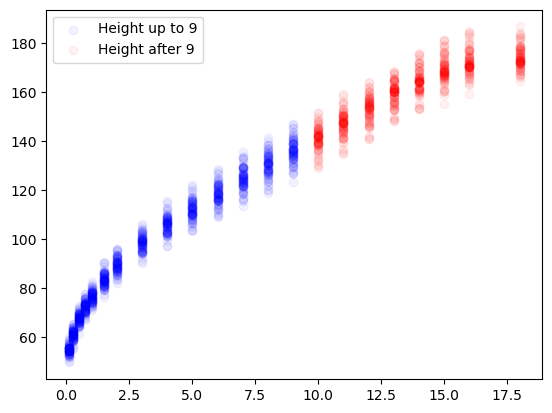

In [193]:
plt.scatter(
    x="AgeGr",
    y="SHgt_cm",
    data=gen2_test,
    color="b",
    alpha=0.05,
    label="Height up to 9",
)
plt.scatter(
    x="age",
    y="height",
    data=melted_df,
    color="r",
    alpha=0.05,
    label="Height after 9",
)
plt.legend()

plt.savefig("forecast")

In [194]:
melted_df[melted_df['child_id'] == 2831]

,child_id,age,height
0,2831,10,139.146454
1,2831,11,145.669037
2,2831,12,151.297012
3,2831,13,158.640549
4,2831,14,164.704193
5,2831,15,167.592987
6,2831,16,170.279541
7,2831,18,171.038986


In [195]:
submission_df = pd.DataFrame(columns=['gen2id_age', 'SHgt_cm'])

submission_df['gen2id_age'] = melted_df['child_id'].astype(str) + '_' + melted_df['age'].astype(str)
submission_df['SHgt_cm'] = melted_df['height']

In [196]:
template = pd.read_csv("gen2_test_solution_template.csv")
template.head()

,gen2id_age,SHgt_cm
0,2831_10,150
1,2831_11,150
2,2831_12,150
3,2831_13,150
4,2831_14,150


In [197]:
submission_df_final = submission_df[submission_df['gen2id_age'].isin(template['gen2id_age'].values)]

In [198]:
len(submission_df_final)

589

In [199]:
submission_df_final.to_csv("prediction.csv", index=False)